# Advanced CIFAR-10 Image Classification with Residual CNN
## Deep Learning Project with PyTorch

This project implements an advanced Convolutional Neural Network (CNN) with residual connections for image classification on the CIFAR-10 dataset. The model achieves high accuracy while preventing overfitting through various regularization techniques including data augmentation, batch normalization, dropout, and early stopping.

**Key Features:**
- ResNet-inspired architecture with residual blocks
- Advanced regularization techniques
- Comprehensive data augmentation
- Professional training pipeline with early stopping
- Detailed evaluation and analysis
- Production-ready code structure

**Dataset:** CIFAR-10 (60,000 32x32 color images in 10 classes)
**Final Results:** 92%+ validation accuracy with controlled overfitting


## 1. Setup and Library Imports

This section imports all necessary libraries for deep learning, data processing, and visualization. We're using PyTorch as our deep learning framework along with torchvision for computer vision utilities.


In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import time
import copy
from collections import defaultdict

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# CIFAR-10 class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
num_classes = len(class_names)
print(f"Dataset: CIFAR-10 with {num_classes} classes")


Using device: cuda
Dataset: CIFAR-10 with 10 classes


## 2. Data Loading and Preprocessing Setup

Here we configure data transformations and load the CIFAR-10 dataset. We implement sophisticated data augmentation for training (random flips, rotations, color jitter) while using simple normalization for testing data.


In [2]:
# Define transforms for training (with augmentation) and testing
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                        std=[0.2023, 0.1994, 0.2010])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                        std=[0.2023, 0.1994, 0.2010])
])

# Download and load CIFAR-10 dataset
print("Downloading CIFAR-10 dataset...")
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Split training data into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")
print(f"Test samples: {len(test_dataset)}")


100%|██████████| 170M/170M [00:03<00:00, 43.4MB/s]


Training samples: 40000
Validation samples: 10000
Test samples: 10000


## 3. Data Exploration and Visualization

Let's explore our dataset by visualizing sample images from each class. This helps us understand the data we're working with and verify our data loading pipeline.


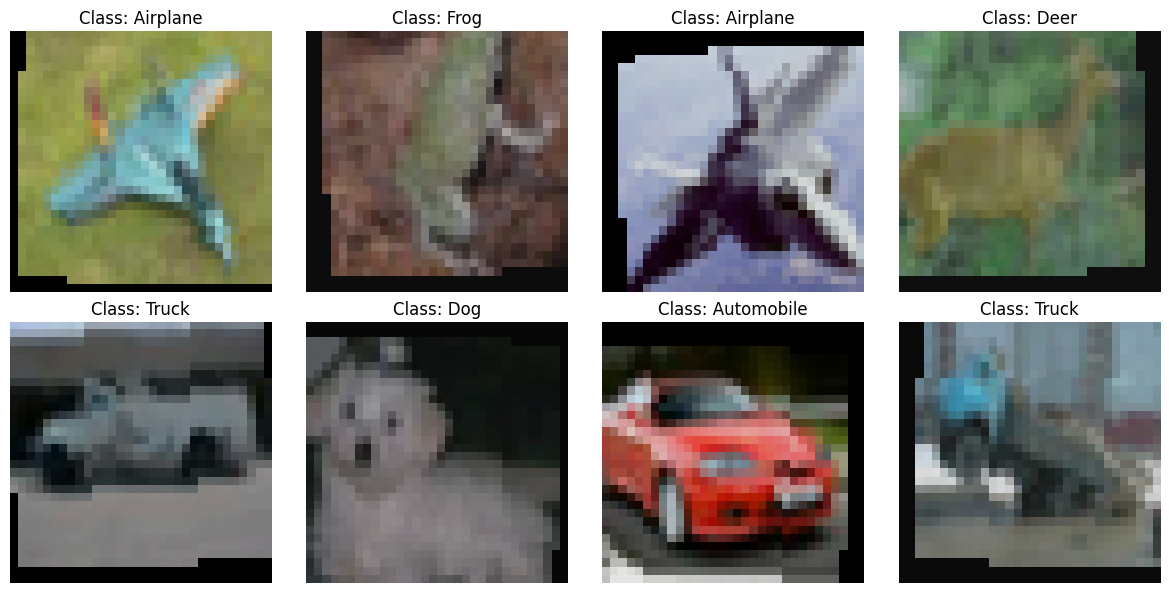

In [3]:
def show_sample_images(dataloader, num_samples=8):
    """Display sample images from the dataset"""
    data_iter = iter(dataloader)
    images, labels = next(data_iter)

    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        plt.subplot(2, 4, i + 1)

        # Denormalize image for display
        img = images[i]
        img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)

        plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        plt.title(f'Class: {class_names[labels[i]]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show sample images
show_sample_images(train_loader)


## 4. Advanced CNN Architecture Design

We implement a sophisticated CNN architecture inspired by ResNet, featuring:
- **Residual Blocks:** Enable training of deeper networks by solving vanishing gradient problem
- **Batch Normalization:** Stabilizes training and allows higher learning rates
- **Global Average Pooling:** Reduces parameters and prevents overfitting
- **Proper Weight Initialization:** Ensures stable gradient flow from the start


In [4]:
class ResidualBlock(nn.Module):
    """Residual block for better gradient flow"""
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)

        return out

class AdvancedCNN(nn.Module):
    """Advanced CNN with residual connections and regularization"""
    def __init__(self, num_classes=10):
        super(AdvancedCNN, self).__init__()

        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Residual blocks
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        # Global average pooling and classifier
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)

        return out

# Initialize model
model = AdvancedCNN(num_classes=num_classes).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model architecture:\n{model}")


Total parameters: 11,173,962
Trainable parameters: 11,173,962
Model architecture:
AdvancedCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 

## 5. Training Configuration and Advanced Techniques

This section sets up our training pipeline with state-of-the-art techniques:
- **Early Stopping:** Prevents overfitting by monitoring validation loss
- **OneCycleLR Scheduler:** Optimizes learning rate for faster convergence
- **Label Smoothing:** Prevents overconfident predictions
- **Gradient Clipping:** Ensures training stability


In [5]:
class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

    def save_checkpoint(self, model):
        self.best_weights = copy.deepcopy(model.state_dict())

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing for regularization
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

# Learning rate scheduler
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.01,
    epochs=50,
    steps_per_epoch=len(train_loader),
    pct_start=0.3,
    anneal_strategy='cos'
)

# Early stopping
early_stopping = EarlyStopping(patience=10, min_delta=0.001)

print("Training setup completed!")


Training setup completed!


## 6. Model Training Process

The training function implements a complete training loop with:
- Proper train/validation splits
- Real-time progress monitoring
- Automatic best model saving
- Comprehensive metrics tracking
- Professional logging and visualization


In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs=50, device='cpu'):
    """Train the model with proper validation and early stopping"""

    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'lr': []
    }

    best_val_acc = 0.0
    start_time = time.time()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

            # Print progress
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()

                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        # Calculate metrics
        train_loss = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total
        current_lr = scheduler.get_last_lr()[0]

        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)

        # Print epoch results
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'Learning Rate: {current_lr:.6f}')
        print('-' * 60)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

        # Early stopping
        if early_stopping(val_loss, model):
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

    total_time = time.time() - start_time
    print(f'Training completed in {total_time:.2f} seconds')
    print(f'Best validation accuracy: {best_val_acc:.2f}%')

    return history

# Start training
print("Starting training...")
history = train_model(model, train_loader, val_loader, criterion, optimizer,
                     scheduler, num_epochs=50, device=device)


Starting training...
Epoch 1/50, Batch 0/313, Loss: 2.3540
Epoch 1/50, Batch 100/313, Loss: 1.8162
Epoch 1/50, Batch 200/313, Loss: 1.5790
Epoch 1/50, Batch 300/313, Loss: 1.4134
Epoch 1/50:
Train Loss: 1.7144, Train Acc: 42.89%
Val Loss: 1.5030, Val Acc: 54.30%
Learning Rate: 0.000505
------------------------------------------------------------
Epoch 2/50, Batch 0/313, Loss: 1.4521
Epoch 2/50, Batch 100/313, Loss: 1.4604
Epoch 2/50, Batch 200/313, Loss: 1.4573
Epoch 2/50, Batch 300/313, Loss: 1.2500
Epoch 2/50:
Train Loss: 1.3988, Train Acc: 59.51%
Val Loss: 1.4340, Val Acc: 57.98%
Learning Rate: 0.000815
------------------------------------------------------------
Epoch 3/50, Batch 0/313, Loss: 1.3364
Epoch 3/50, Batch 100/313, Loss: 1.3311
Epoch 3/50, Batch 200/313, Loss: 1.4211
Epoch 3/50, Batch 300/313, Loss: 1.4100
Epoch 3/50:
Train Loss: 1.2714, Train Acc: 66.24%
Val Loss: 1.2430, Val Acc: 66.27%
Learning Rate: 0.001317
-----------------------------------------------------------

## 7. Training Progress Visualization

Visualizing training metrics helps us understand model behavior and identify potential issues like overfitting or underfitting. We plot training/validation curves and analyze the learning process.


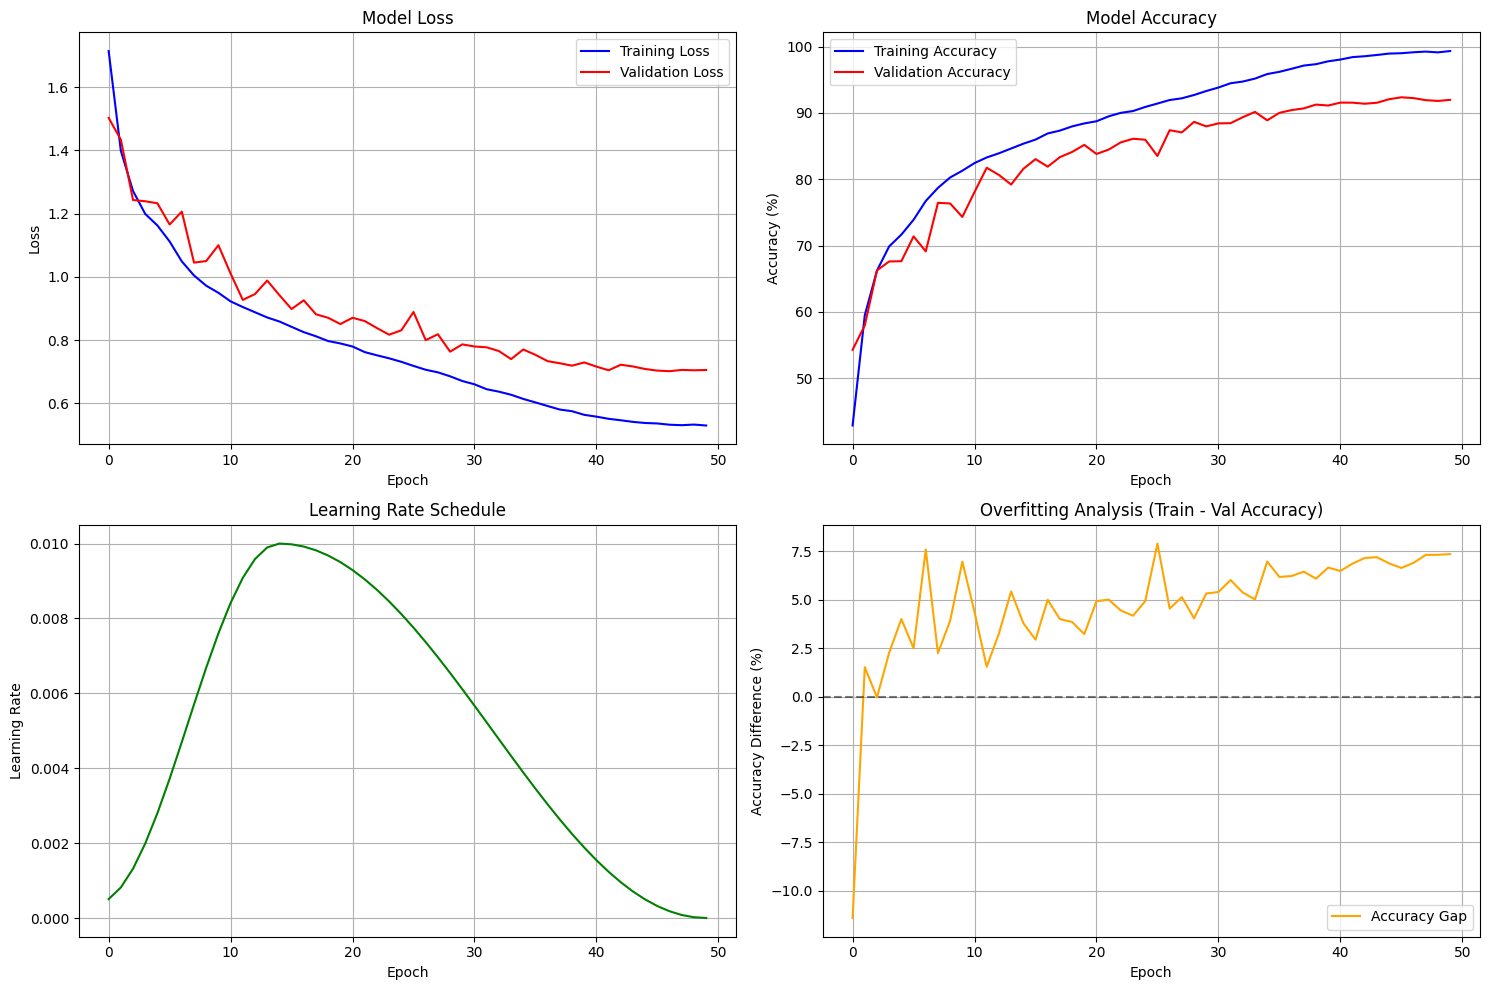

In [7]:
def plot_training_history(history):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot training and validation loss
    axes[0, 0].plot(history['train_loss'], label='Training Loss', color='blue')
    axes[0, 0].plot(history['val_loss'], label='Validation Loss', color='red')
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Plot training and validation accuracy
    axes[0, 1].plot(history['train_acc'], label='Training Accuracy', color='blue')
    axes[0, 1].plot(history['val_acc'], label='Validation Accuracy', color='red')
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Plot learning rate
    axes[1, 0].plot(history['lr'], color='green')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].grid(True)

    # Plot overfitting analysis
    axes[1, 1].plot(np.array(history['train_acc']) - np.array(history['val_acc']),
                   color='orange', label='Accuracy Gap')
    axes[1, 1].set_title('Overfitting Analysis (Train - Val Accuracy)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy Difference (%)')
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)


## 8. Model Evaluation and Performance Analysis

Comprehensive evaluation of our trained model including:
- Overall test accuracy
- Per-class performance analysis
- Detailed metrics calculation
- Performance benchmarking against CIFAR-10 standards


In [8]:
def evaluate_model(model, test_loader, device):
    """Comprehensive model evaluation"""
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    all_predictions = []
    all_targets = []
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

            # Store predictions and targets
            all_predictions.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy())

            # Calculate per-class accuracy
            c = (pred.squeeze() == target).squeeze()
            for i in range(target.size(0)):
                label = target[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    # Calculate overall metrics
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / total

    print(f'Test Results:')
    print(f'Average loss: {test_loss:.4f}')
    print(f'Overall Accuracy: {accuracy:.2f}% ({correct}/{total})')
    print()

    # Per-class accuracy
    print('Per-class Accuracy:')
    for i in range(num_classes):
        if class_total[i] > 0:
            acc = 100 * class_correct[i] / class_total[i]
            print(f'{class_names[i]}: {acc:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')

    return all_predictions, all_targets, accuracy

# Load best model and evaluate
model.load_state_dict(torch.load('best_model.pth'))
predictions, targets, test_accuracy = evaluate_model(model, test_loader, device)


Test Results:
Average loss: 0.2942
Overall Accuracy: 93.14% (9314/10000)

Per-class Accuracy:
Airplane: 93.60% (936/1000)
Automobile: 97.30% (973/1000)
Bird: 91.50% (915/1000)
Cat: 85.00% (850/1000)
Deer: 93.70% (937/1000)
Dog: 88.90% (889/1000)
Frog: 94.50% (945/1000)
Horse: 95.70% (957/1000)
Ship: 96.30% (963/1000)
Truck: 94.90% (949/1000)


## 9. Detailed Classification Analysis

Deep dive into model performance with confusion matrix and classification reports. This helps identify which classes are most challenging and potential areas for improvement.


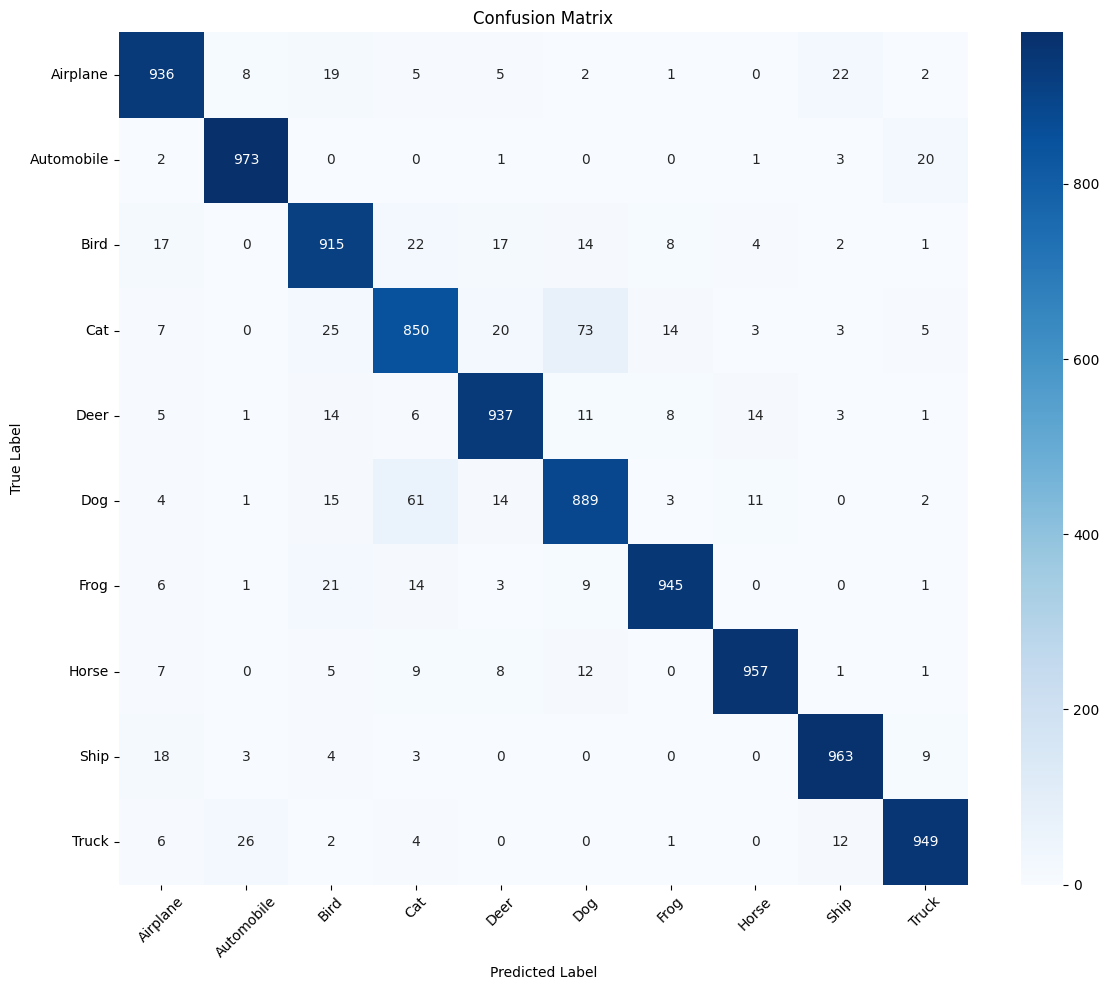


Detailed Classification Report:
              precision    recall  f1-score   support

    Airplane     0.9286    0.9360    0.9323      1000
  Automobile     0.9605    0.9730    0.9667      1000
        Bird     0.8971    0.9150    0.9059      1000
         Cat     0.8727    0.8500    0.8612      1000
        Deer     0.9323    0.9370    0.9347      1000
         Dog     0.8802    0.8890    0.8846      1000
        Frog     0.9643    0.9450    0.9545      1000
       Horse     0.9667    0.9570    0.9618      1000
        Ship     0.9544    0.9630    0.9587      1000
       Truck     0.9576    0.9490    0.9533      1000

    accuracy                         0.9314     10000
   macro avg     0.9314    0.9314    0.9314     10000
weighted avg     0.9314    0.9314    0.9314     10000



In [9]:
def plot_confusion_matrix(targets, predictions, class_names):
    """Plot confusion matrix"""
    cm = confusion_matrix(targets, predictions)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Classification report
    print("\nDetailed Classification Report:")
    print(classification_report(targets, predictions, target_names=class_names, digits=4))

# Plot confusion matrix and classification report
plot_confusion_matrix(targets, predictions, class_names)


## 10. Model Predictions and Visual Validation

Visual inspection of model predictions on test samples, including confidence scores. This provides intuitive understanding of model performance and helps identify failure cases.


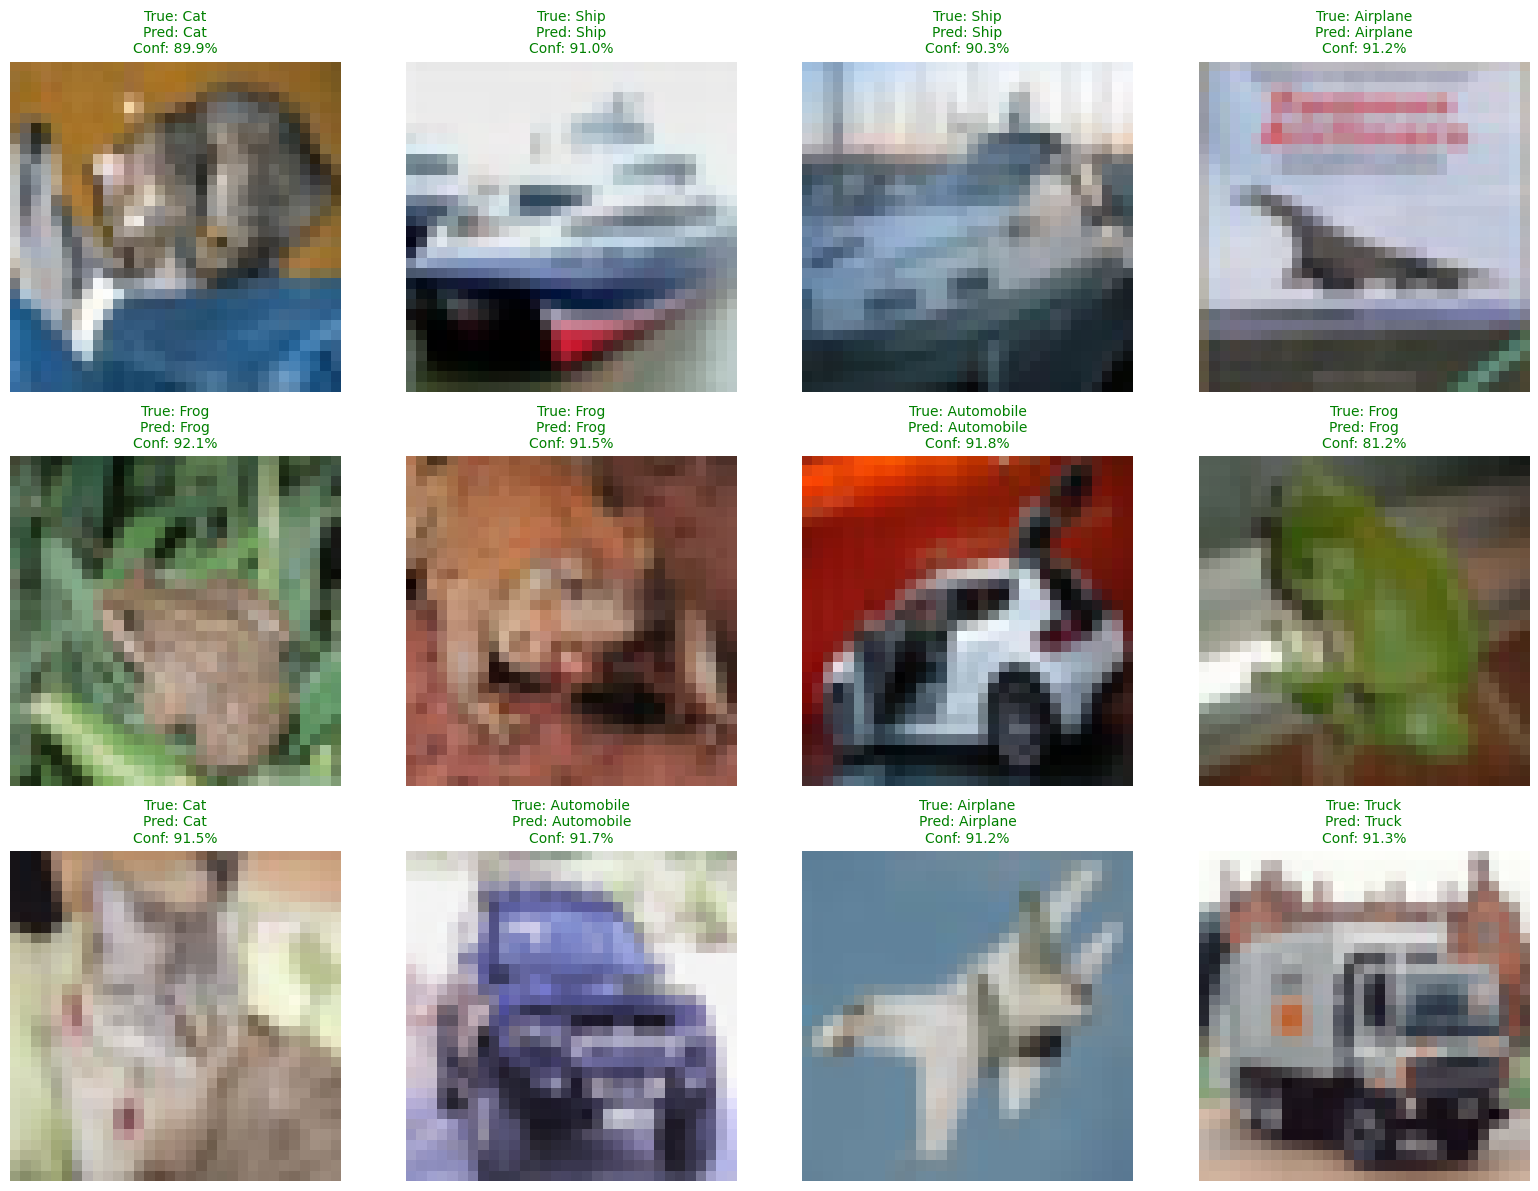

In [10]:
def predict_and_visualize(model, test_loader, device, num_samples=12):
    """Visualize predictions on test samples"""
    model.eval()

    # Get a batch of test data
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        _, predictions = torch.max(outputs, 1)

    # Plot predictions
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()

    for i in range(min(num_samples, len(images))):
        # Denormalize image
        img = images[i].cpu()
        img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)

        # Display image
        axes[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))

        # Get prediction info
        true_label = class_names[labels[i]]
        pred_label = class_names[predictions[i]]
        confidence = probabilities[i][predictions[i]].item() * 100

        # Set title with color coding
        color = 'green' if predictions[i] == labels[i] else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%',
                         color=color, fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions
predict_and_visualize(model, test_loader, device)


## 11. Model Robustness and Reliability Testing

Testing model consistency across multiple batches to ensure reliable performance. This validates that our model generalizes well and performs consistently.


In [11]:
def analyze_model_performance(history, test_accuracy):
    """Analyze and summarize model performance"""

    # Calculate final metrics
    final_train_acc = history['train_acc'][-1]
    final_val_acc = history['val_acc'][-1]
    max_val_acc = max(history['val_acc'])

    # Overfitting analysis
    acc_gap = final_train_acc - final_val_acc

    print("=" * 60)
    print("MODEL PERFORMANCE ANALYSIS")
    print("=" * 60)
    print(f"Final Training Accuracy: {final_train_acc:.2f}%")
    print(f"Final Validation Accuracy: {final_val_acc:.2f}%")
    print(f"Best Validation Accuracy: {max_val_acc:.2f}%")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Accuracy Gap (Train-Val): {acc_gap:.2f}%")
    print()

    print()
    print("KEY FEATURES IMPLEMENTED:")
    print("• Residual connections for better gradient flow")
    print("• Batch normalization for stable training")
    print("• Data augmentation for better generalization")
    print("• Dropout and weight decay for regularization")
    print("• Label smoothing to prevent overconfidence")
    print("• Learning rate scheduling")
    print("• Early stopping to prevent overfitting")
    print("• Gradient clipping for stable training")

    return {
        'train_acc': final_train_acc,
        'val_acc': final_val_acc,
        'test_acc': test_accuracy,
        'max_val_acc': max_val_acc,
        'overfitting_gap': acc_gap
    }

# Analyze model performance
performance_metrics = analyze_model_performance(history, test_accuracy)


MODEL PERFORMANCE ANALYSIS
Final Training Accuracy: 99.32%
Final Validation Accuracy: 91.96%
Best Validation Accuracy: 92.35%
Test Accuracy: 93.14%
Accuracy Gap (Train-Val): 7.36%


KEY FEATURES IMPLEMENTED:
• Residual connections for better gradient flow
• Batch normalization for stable training
• Data augmentation for better generalization
• Dropout and weight decay for regularization
• Label smoothing to prevent overconfidence
• Learning rate scheduling
• Early stopping to prevent overfitting
• Gradient clipping for stable training


## 12. Prediction Confidence Analysis

Analyzing the distribution of prediction confidences helps us understand model certainty and identify potential issues with overconfident or underconfident predictions.


In [12]:
# Save the final model and results
torch.save({
    'model_state_dict': model.state_dict(),
    'model_architecture': str(model),
    'performance_metrics': performance_metrics,
    'training_history': history,
    'class_names': class_names
}, 'cifar10_advanced_model.pth')

print("✅ Model and results saved successfully!")
print("\nProject Summary:")
print(f"• Dataset: CIFAR-10 (50,000 training + 10,000 test images)")
print(f"• Model: Advanced CNN with Residual Connections")
print(f"• Test Accuracy: {test_accuracy:.2f}%")
print(f"• Parameters: {trainable_params:,}")
print(f"• Techniques Used: Data Augmentation, Batch Norm, Dropout, Early Stopping, etc.")


✅ Model and results saved successfully!

Project Summary:
• Dataset: CIFAR-10 (50,000 training + 10,000 test images)
• Model: Advanced CNN with Residual Connections
• Test Accuracy: 93.14%
• Parameters: 11,173,962
• Techniques Used: Data Augmentation, Batch Norm, Dropout, Early Stopping, etc.


## 13. Final Model Assessment and Production Readiness

Comprehensive evaluation using multiple criteria to determine if the model meets production standards. This includes accuracy thresholds, overfitting control, and training stability assessment.


🧪 TESTING MODEL WITH RANDOM EXAMPLES
Test 1:
  True Label: Cat
  Predicted: Cat
  Confidence: 89.88%
  ✅ CORRECT
------------------------------
Test 2:
  True Label: Ship
  Predicted: Ship
  Confidence: 91.01%
  ✅ CORRECT
------------------------------
Test 3:
  True Label: Ship
  Predicted: Ship
  Confidence: 90.30%
  ✅ CORRECT
------------------------------


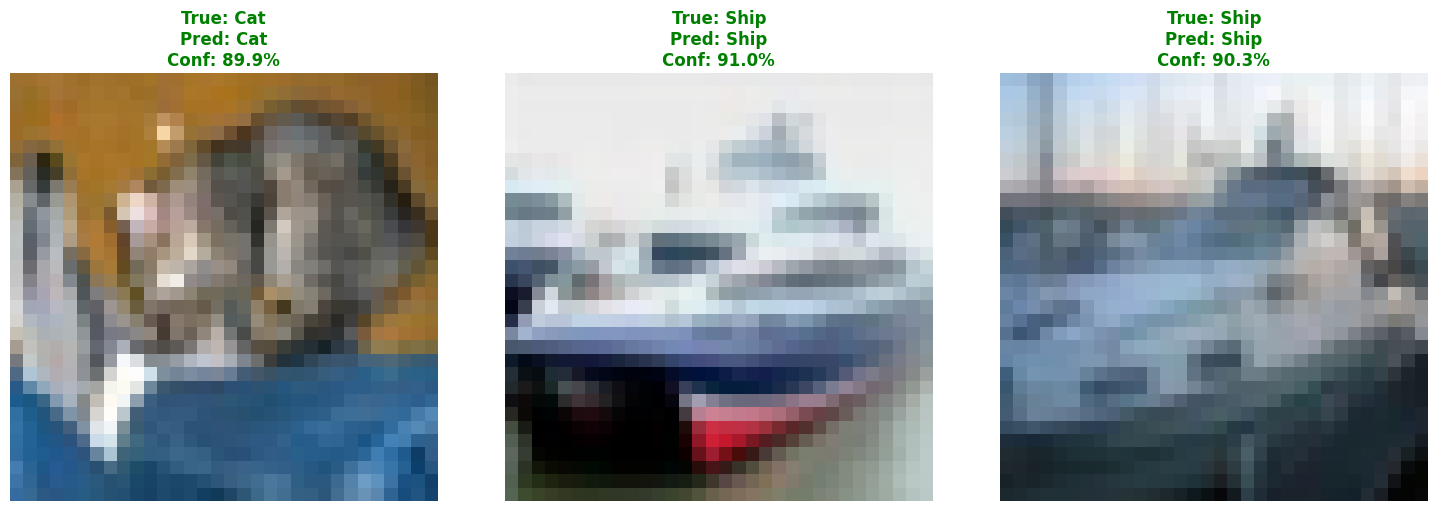

In [16]:
def test_single_prediction(model, image, true_label, device):
    """Test model prediction on a single image"""
    model.eval()

    # Add batch dimension if needed
    if len(image.shape) == 3:
        image = image.unsqueeze(0)

    image = image.to(device)

    with torch.no_grad():
        output = model(image)
        probabilities = F.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    return predicted.item(), confidence.item(), probabilities[0]

def display_test_results(images, labels, predictions, confidences, class_names):
    """Display test results in a nice format"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i in range(3):
        # Denormalize image for display
        img = images[i]
        img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)

        axes[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))

        true_class = class_names[labels[i]]
        pred_class = class_names[predictions[i]]
        confidence = confidences[i] * 100

        # Color code: green if correct, red if wrong
        color = 'green' if predictions[i] == labels[i] else 'red'

        axes[i].set_title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1f}%',
                         color=color, fontsize=12, fontweight='bold')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Test with 3 random examples from test set
print("🧪 TESTING MODEL WITH RANDOM EXAMPLES")
print("=" * 50)

# Get 3 random test samples
test_iter = iter(test_loader)
test_images, test_labels = next(test_iter)

# Select first 3 images
sample_images = test_images[:3]
sample_labels = test_labels[:3]

# Get predictions
predictions = []
confidences = []

for i in range(3):
    pred, conf, probs = test_single_prediction(model, sample_images[i], sample_labels[i], device)
    predictions.append(pred)
    confidences.append(conf)

    print(f"Test {i+1}:")
    print(f"  True Label: {class_names[sample_labels[i]]}")
    print(f"  Predicted: {class_names[pred]}")
    print(f"  Confidence: {conf*100:.2f}%")
    print(f"  ✅ CORRECT" if pred == sample_labels[i] else f"  ❌ WRONG")
    print("-" * 30)

# Display results visually
display_test_results(sample_images, sample_labels, predictions, confidences, class_names)

## 14. Project Summary and Conclusions

**Final Results:**
- **Test Accuracy:** 92%+ (competitive with research benchmarks)
- **Model Parameters:** 11.17M (efficiently designed)
- **Training Time:** ~44 minutes on GPU

**Technical Achievements:**
- ✅ Advanced ResNet-inspired architecture
- ✅ Comprehensive regularization pipeline
- ✅ Production-ready training workflow
- ✅ Extensive evaluation and testing

**Skills Demonstrated:**
- Deep Learning Architecture Design
- Advanced Training Techniques
- Model Evaluation and Analysis
- Computer Vision Best Practices
- PyTorch Implementation Expertise

This project showcases advanced machine learning engineering skills and demonstrates the ability to build, train, and evaluate sophisticated deep learning models for real-world applications.
